In [1]:
from collections import defaultdict

import numpy as np
import scipy.stats as sps

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import pandas
import gpxpy
import xml.etree.ElementTree as etree

from scipy.ndimage import gaussian_filter

%matplotlib inline

/home/eveline/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/eveline/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def gpx_to_dataframe(gpx_filename):
    with open(gpx_filename, 'r') as f:
        gpx_file = gpxpy.parse(f)
    
    data = defaultdict(list)   
    
    #tracks, segments, points
    for track_id, track in enumerate(gpx_file.tracks):
        for segment_id, segment in enumerate(track.segments):
            for point_id, point in enumerate(segment.points):
                data['track'].append(track_id)
                data['segment'].append(segment_id)
                data['point'].append(point_id)
                data['latitude'].append(point.latitude)
                data['longitude'].append(point.longitude)
                data['elevation'].append(point.elevation)
                data['time'].append(point.time)
                data['speed'].append(segment.get_speed(point_id))
                
    #gpxpy doesn't parse complex extensions
    root_tree = etree.parse(gpx_filename).getroot()
    for extension in root_tree.iter('{http://www.garmin.com/xmlschemas/TrackPointExtension/v1}hr'):
        data['heart_rate'].append(extension.text)
        
    assert len(data['heart_rate']) == len(data['point'])

    return pandas.DataFrame(data, columns=['track', 'segment', 'point', 'latitude', 'longitude',
                                           'elevation', 'time', 'speed', 'heart_rate'])

In [3]:
file_name = 'run-20170322T185334.gpx'  # 'run-20170320T185959.gpx'

In [4]:
df = gpx_to_dataframe(file_name)  # 20170219_162947.gpx

In [5]:
print(df['segment'].max() + 1)
print(df['track'].max() + 1)

2
1


In [6]:
def speed_to_pace(row):
    """m/s to min/km"""
    s = row['speed']
    if np.isnan(s) or s == 0:
        return np.nan
    return 1000/(s*60)

df['pace'] = df.apply(speed_to_pace, axis=1)

In [7]:
df.head()

,track,segment,point,latitude,longitude,elevation,time,speed,heart_rate,pace
0,0,0,0,59.338914,18.021477,15.2,2017-03-22 17:55:34,NaN,120,NaN
1,0,0,1,59.338909,18.021431,15.3,2017-03-22 17:55:35,2.693881,122,6.186862
2,0,0,2,59.338904,18.021384,15.3,2017-03-22 17:55:36,2.786771,123,5.980637
3,0,0,3,59.338901,18.021334,15.3,2017-03-22 17:55:37,2.881019,125,5.784991
4,0,0,4,59.338898,18.021283,15.3,2017-03-22 17:55:38,2.960353,126,5.629959


In [8]:
df.tail()

,track,segment,point,latitude,longitude,elevation,time,speed,heart_rate,pace
1917,0,0,1917,59.331031,18.050756,22.4,2017-03-22 18:27:31,2.545019,162,6.548739
1918,0,0,1918,59.331051,18.050733,22.3,2017-03-22 18:27:32,2.577503,162,6.466206
1919,0,0,1919,59.331071,18.050710,22.3,2017-03-22 18:27:33,2.612106,163,6.380547
1920,0,0,1920,59.331092,18.050688,22.2,2017-03-22 18:27:34,2.647680,163,6.294820
1921,0,1,0,59.331114,18.050666,22.1,2017-03-22 18:27:35,NaN,162,NaN


In [9]:
plot_data = df[df['segment'] == 0]

In [10]:
print(plot_data['longitude'].min())
print(plot_data['longitude'].max())

print(plot_data['latitude'].min())
print(plot_data['latitude'].max())

17.996741
18.054711
59.326359
59.340681


In [11]:
print('Average speed: %.2f km/h' % (np.nanmean(plot_data['speed']) * 3.6))
print('Average pace: %.2f min'% np.nanmean(plot_data['pace']))

Average speed: 11.21 km/h
Average pace: 5.45 min


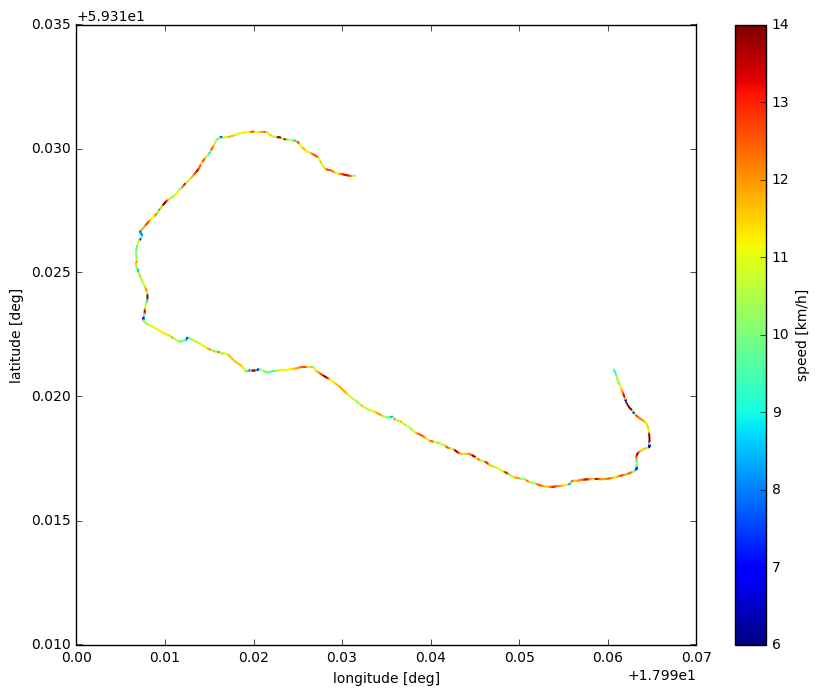

In [12]:
plt.figure(figsize=(10,8))
plt.scatter(plot_data['longitude'],
            plot_data['latitude'],
            c=np.clip(plot_data['speed']*3.6, 6, 14), s=2, lw=0)
plt.colorbar(label='speed [km/h]')
plt.xlabel('longitude [deg]')
plt.ylabel('latitude [deg]')
plt.show()

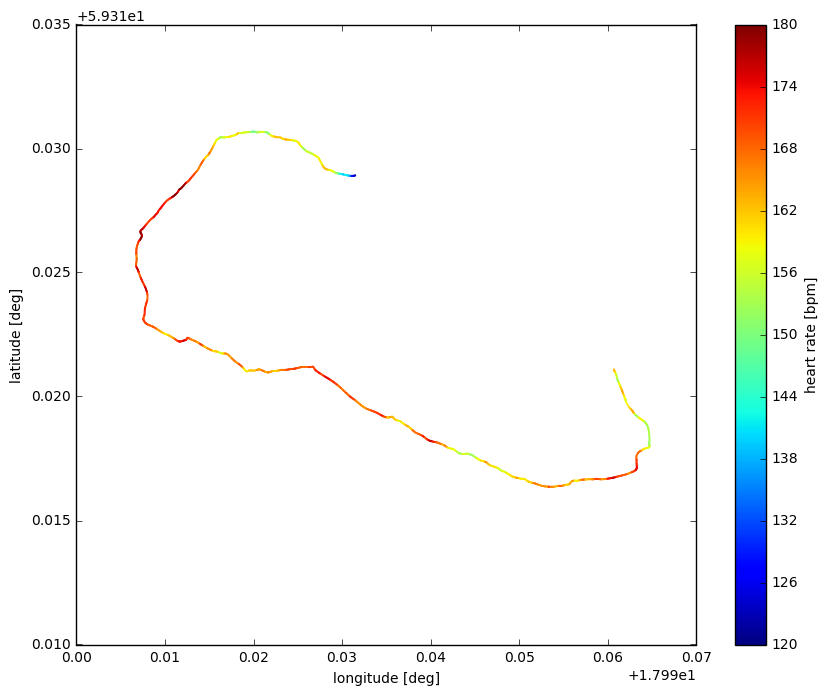

In [13]:
plt.figure(figsize=(10,8))
plt.scatter(plot_data['longitude'],
            plot_data['latitude'],
            c=plot_data['heart_rate'], s=2, lw=0)
plt.colorbar(label='heart rate [bpm]')
plt.xlabel('longitude [deg]')
plt.ylabel('latitude [deg]')
plt.show()

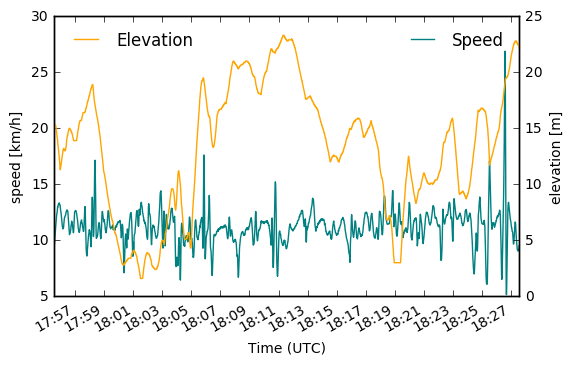

In [14]:
plt.figure()
plt.plot(plot_data['time'], plot_data['speed']*3.6, color='teal', label='Speed')
plt.ylabel('speed [km/h]')
plt.legend(loc='upper right', ncol=1, frameon=0)
plt.xlabel("Time (UTC)")
plt.twinx()
plt.plot(plot_data['time'], plot_data['elevation'], color='orange', label='Elevation')
#plt.plot(plot_data['time'], plot_data['heart_rate'], label='heart rate')

plt.ylabel('elevation [m]')

plt.legend(loc='upper left', ncol=1, frameon=0)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=2))
plt.gcf().autofmt_xdate()
#plt.title("Speed vs time")
plt.xlabel("Time (UTC)")
#plt.ylabel("Speed [km/h]")
plt.show()


In [15]:
# low pass filter
df['smooth'] = gaussian_filter(df['speed'], 6)

In [16]:
plot_data = df[df['segment'] == 0]

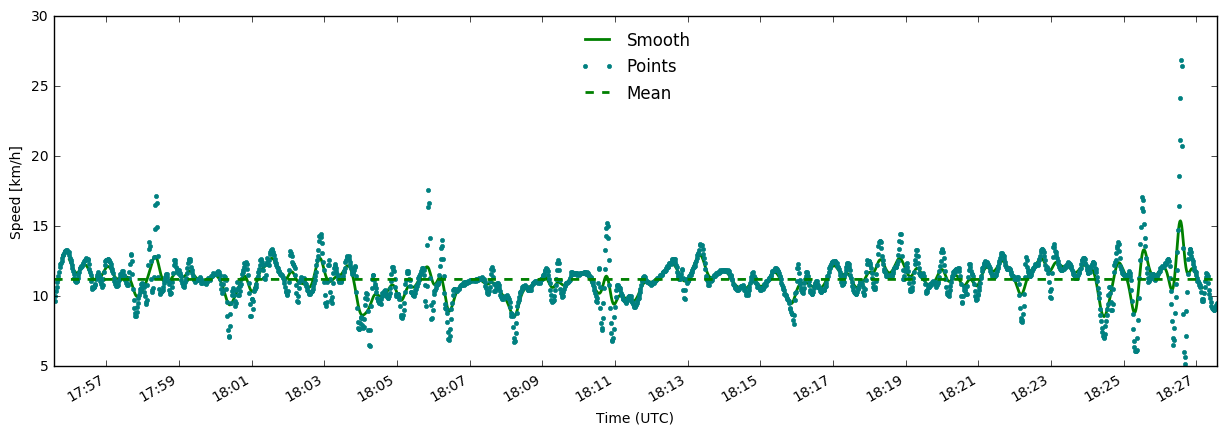

In [17]:
plt.figure(figsize=(15,5))
plt.plot(plot_data['time'], 3.6 * plot_data['smooth'], 'g-', label='Smooth', linewidth=2)
plt.plot(plot_data['time'], 3.6 * plot_data['speed'], '.', color='teal', label='Points')
plt.plot(plot_data['time'], [3.6 * np.nanmean(plot_data['speed'])] * len(plot_data['speed']), 'g--',  label='Mean', linewidth=2)

plt.legend(loc='upper center', ncol=1, frameon=0)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=2))
plt.gcf().autofmt_xdate()
#plt.title("Speed vs time")
plt.xlabel("Time (UTC)")
plt.ylabel("Speed [km/h]")
plt.show()

In [18]:
# Plot on google maps

In [20]:
import gmplot

In [21]:
gmap = gmplot.GoogleMapPlotter(np.nanmean(plot_data['latitude']), np.nanmean(plot_data['longitude']), 15)

In [22]:
gmap.plot(plot_data['latitude'].values, plot_data['longitude'].values, 'cornflowerblue', edge_width=4)
#gmap.heatmap(plot_data['latitude'].values, plot_data['longitude'])  #.values, size=1, marker=False)
gmap.draw('test.html')